In [1]:
import numpy as np
import sys
import torch
torch.set_num_threads(2)

from functools import partial

from kusanagi.shell import cartpole
from kusanagi.base import ExperienceDataset, apply_controller
from kusanagi.ghost.control import RandPolicy

from prob_mbrl import utils, models, algorithms, losses, train_regressor

In [2]:
def forward(states, actions, dynamics, **kwargs):
    deltas, rewards = dyn((states, actions), return_samples=True,
                           separate_outputs=True, **kwargs)
    next_states = states + deltas
    return next_states, rewards

In [3]:
env = cartpole.Cartpole()
target = torch.tensor([0,0,0,np.pi]).float()
D = target.shape[-1]
U = 1
learn_reward = False
maxU = np.array([10.0])     
angle_dims = torch.tensor([3]).long()
target = utils.to_complex(target, angle_dims)
Da = target.shape[-1]
Q = torch.zeros(Da, Da).float()
Q[0, 0] = 1
Q[0, -2] = env.l
Q[-2, 0] = env.l
Q[-2, -2] = env.l**2
Q[-1, -1] = env.l**2
Q /= 0.1
def reward_func(states, target, Q, angle_dims):
    states = utils.to_complex(states, angle_dims)
    reward = losses.quadratic_saturating_loss(states, target, Q)
    return reward

n_components = 5
dynE = 2*(D+1) if learn_reward else 2*D
reward_func = None if learn_reward else partial(reward_func, target=target, Q=Q, angle_dims=angle_dims)
dyn = models.DynamicsModel(
        models.dropout_mlp(
            Da+U, (dynE+1)*5, [200]*2,
            dropout_layers=[models.modules.CDropout(0.5, 1.0)]*2,
            nonlin=torch.nn.ReLU,
        ),
        reward_func=reward_func, angle_dims=angle_dims,
        output_density=models.MixtureDensity(dynE/2, 5)
    ).float()
pol = models.Policy(
    models.dropout_mlp(
        Da, U, output_nonlin=torch.nn.Tanh,
        dropout_layers=[models.modules.BDropout(0.1)]*2),
    maxU, angle_dims=angle_dims).float()
randpol = RandPolicy(maxU)
exp = ExperienceDataset()
params = filter(lambda p: p.requires_grad, pol.parameters())
opt = torch.optim.Adam(params, 1e-4, amsgrad=True)

forward_fn = partial(forward, dynamics=dyn)


[2018-07-11 15:08:34.554014] Experience > Initialising new experience dataset


In [4]:
#%matplotlib qt
def cb(*args, **kwargs):
    env.render()

H = 25
N_particles = 100
for rand_it in range(1):
    ret = apply_controller(env, randpol, H, callback=None)
    exp.append_episode(*ret)

[2018-07-11 15:08:34.567535] apply_controller > Starting run
[2018-07-11 15:08:34.569111] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:08:34.695835] apply_controller > Done. Stopping robot. Value of run [24.986395]
[2018-07-11 15:08:34.697225] Cartpole > Stopping robot


[2018-07-11 15:08:34.726773] apply_controller > Starting run
[2018-07-11 15:08:34.728102] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:08:34.892128] apply_controller > Done. Stopping robot. Value of run [23.275227]
[2018-07-11 15:08:34.894131] Cartpole > Stopping robot


log-likelihood of data: -1.096871:  99%|█████████▉| 990/1000 [00:07<00:00, 127.06it/s]


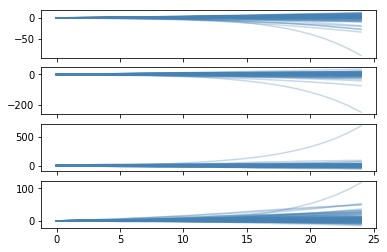

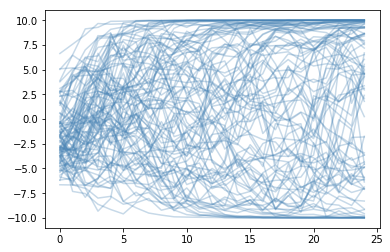

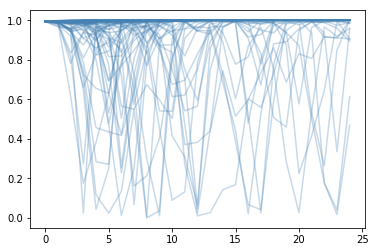

/home/juancamilog/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Accumulated costs: 0.965295:   0%|          | 1/1000 [00:00<02:11,  7.57it/s]

Policy search iteration 1


Accumulated costs: 0.900613: 100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


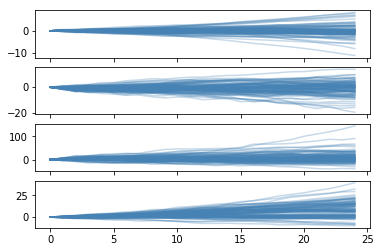

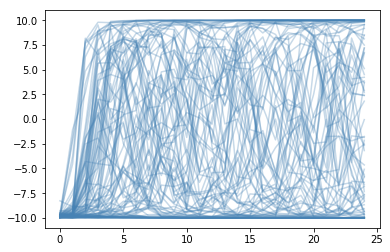

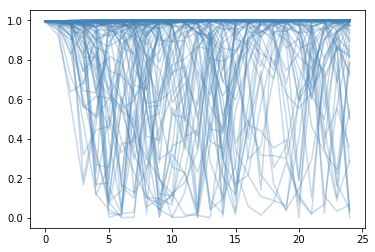

[2018-07-11 15:10:57.822915] apply_controller > Starting run
[2018-07-11 15:10:57.824810] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:10:57.968449] apply_controller > Done. Stopping robot. Value of run [24.848362]
[2018-07-11 15:10:57.970078] Cartpole > Stopping robot


log-likelihood of data: 0.289322: 100%|█████████▉| 999/1000 [00:09<00:00, 109.36it/s] 


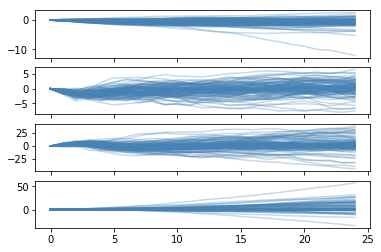

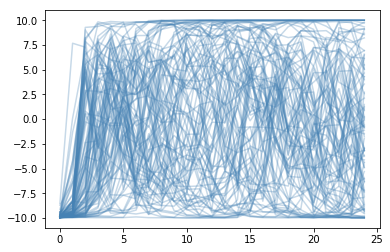

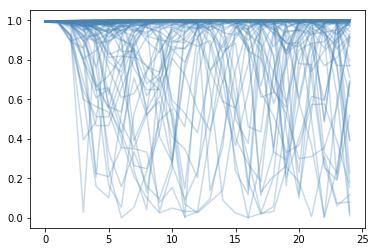

Accumulated costs: 0.927660:   0%|          | 1/1000 [00:00<02:16,  7.32it/s]

Policy search iteration 2


Accumulated costs: 0.836615: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]


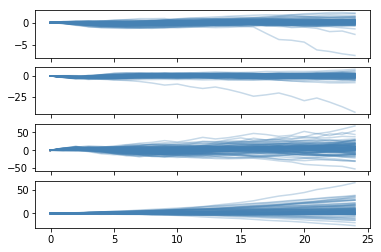

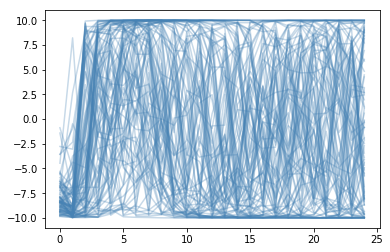

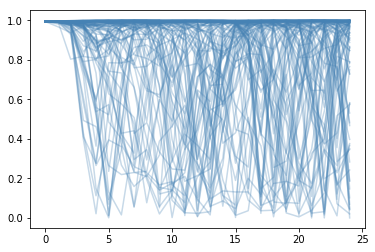

[2018-07-11 15:13:06.321581] apply_controller > Starting run
[2018-07-11 15:13:06.323175] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:13:06.478338] apply_controller > Done. Stopping robot. Value of run [22.646816]
[2018-07-11 15:13:06.479617] Cartpole > Stopping robot


log-likelihood of data: 0.941967: 100%|██████████| 1000/1000 [00:09<00:00, 107.36it/s]


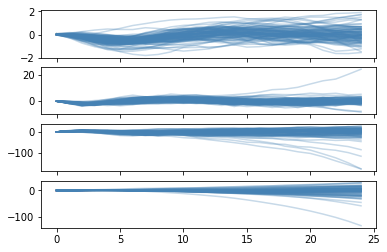

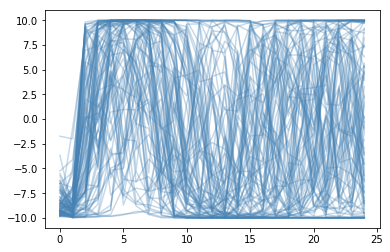

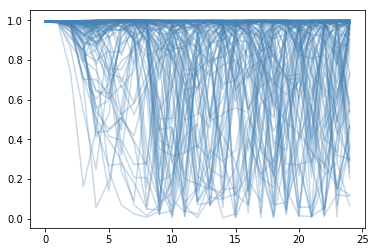

Accumulated costs: 0.859345:   0%|          | 1/1000 [00:00<01:49,  9.10it/s]

Policy search iteration 3


Accumulated costs: 0.830408: 100%|██████████| 1000/1000 [01:55<00:00,  8.65it/s]


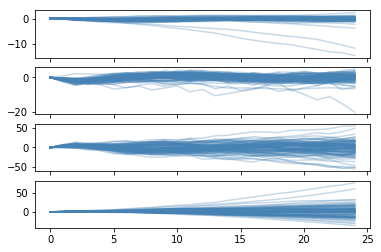

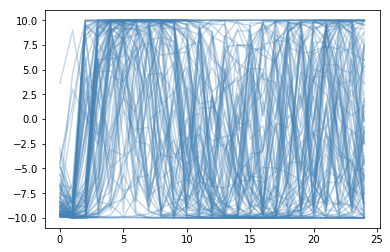

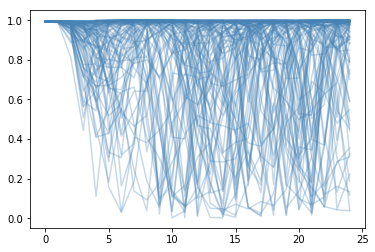

[2018-07-11 15:15:16.540664] apply_controller > Starting run
[2018-07-11 15:15:16.542070] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:15:16.712614] apply_controller > Done. Stopping robot. Value of run [19.510040]
[2018-07-11 15:15:16.714380] Cartpole > Stopping robot


log-likelihood of data: 1.297565: 100%|██████████| 1000/1000 [00:08<00:00, 113.11it/s]


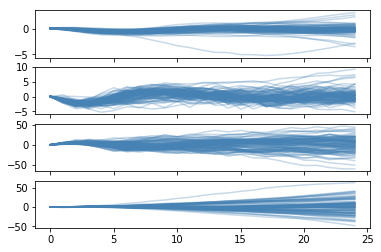

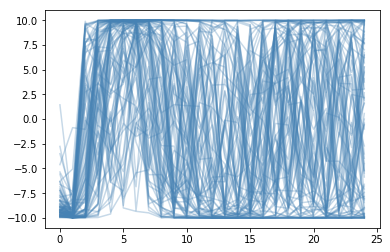

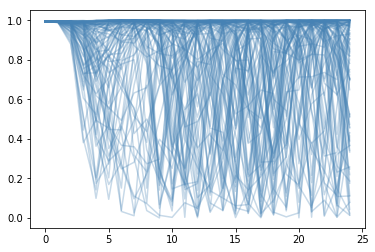

Accumulated costs: 0.832230:   0%|          | 1/1000 [00:00<01:59,  8.39it/s]

Policy search iteration 4


Accumulated costs: 0.842719: 100%|██████████| 1000/1000 [02:05<00:00,  7.98it/s]


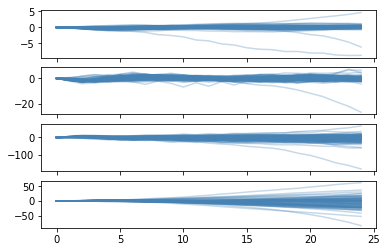

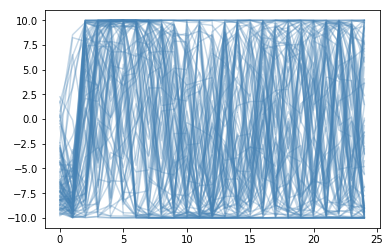

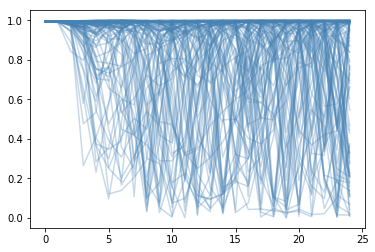

[2018-07-11 15:17:36.024995] apply_controller > Starting run
[2018-07-11 15:17:36.026319] apply_controller > Running for 2.500000 seconds
[2018-07-11 15:17:36.184078] apply_controller > Done. Stopping robot. Value of run [22.658632]
[2018-07-11 15:17:36.185377] Cartpole > Stopping robot


log-likelihood of data: 1.632664: 100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


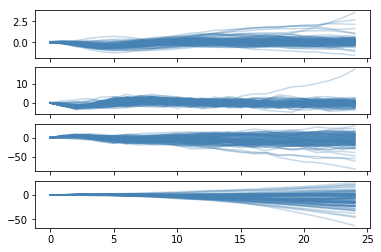

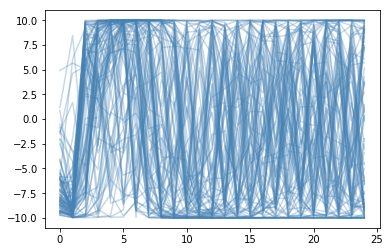

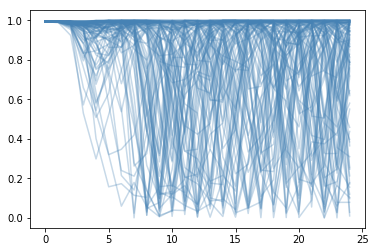

  0%|          | 0/1000 [00:00<?, ?it/s]

Policy search iteration 5


Accumulated costs: 0.833743:   3%|▎         | 33/1000 [00:06<03:23,  4.75it/s]

In [ ]:
for ps_it in range(100):
    # apply policy
    ret = apply_controller(env, pol, H, callback=None)
    exp.append_episode(*ret)

    # train dynamics
    X, Y = exp.get_dynmodel_dataset(deltas=True, return_costs=learn_reward)
    dyn.set_dataset(torch.tensor(X).to(dyn.X.device).float(), torch.tensor(Y).to(dyn.X.device).float())  
    train_regressor(dyn, 1000, N_particles, True, log_likelihood=losses.gaussian_mixture_log_likelihood)
    x0 = torch.tensor(exp.sample_states(N_particles, timestep=0)).to(dyn.X.device).float()
    x0 += 1e-2*x0.std(0)*torch.randn_like(x0)
    utils.plot_rollout(x0, forward_fn, pol, H)
    
    # train policy
    print "Policy search iteration %d" % (ps_it+1)
    algorithms.mc_pilco(x0, forward_fn, dyn, pol, H, opt, exp=exp,
             maximize=False, pegasus=False, mm_states=False,
             mm_rewards=False, mpc=False, max_steps=25)
    utils.plot_rollout(x0, forward_fn, pol, H)
    

In [89]:
def jac1(f, x, out_dims=None):
    if out_dims is None:
        y = f(x)
        out_dims = y.shape[-1]
    x_rep = x.repeat(out_dims, 1)
    x_rep = torch.tensor(x_rep, requires_grad=True)
    y_rep = f(x_rep)
    dydx = torch.autograd.grad(
        y_rep, x_rep, torch.eye(x1.shape[-1]),
        allow_unused=True, retain_graph=True)
    return dydx
    

In [100]:
inps =  torch.cat([x0, pol(x0, resample=False)], -1)
dyn.
jac1(lambda x: dyn(x, resample=False)[0], inps)

tensor([-0.0328, -0.0424,  0.1437, -0.0073,  8.0338])


(tensor([[ 0.0981, -0.0457, -0.0044,  0.0119, -0.1534],
         [ 0.1973, -0.2845,  0.0820, -0.0410, -0.0081],
         [ 0.1663,  0.2058, -0.0057, -0.1639, -0.0829],
         [ 0.0822, -0.2351,  0.0319,  0.0580,  0.1469],
         [ 0.0120, -0.1477,  0.1949, -0.3201, -0.0830]]),)

In [81]:
dyn(torch.cat([x0, pol(x0, resample=False)], -1), resample=False)

(tensor([[ 1.3330e+23, -1.0334e+22, -3.1767e+22, -1.8909e+23,  3.2496e+23]]),
 tensor([[ 7.6010e+22,  1.9934e+23,  4.0687e+22,  1.7132e+23,  1.3190e+23]]))

In [82]:
torch.ze

AttributeError: 'Tensor' object has no attribute 'zero_grad'

In [15]:
%timeit torch.tensor(1).random_(0,100)

The slowest run took 43.48 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.48 µs per loop


In [9]:
%timeit torch.randperm(x0.shape[0])

The slowest run took 46.28 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.23 µs per loop


In [6]:
torch.random.ch

Parameter containing:
tensor([[  0.1285,  -0.0661,  -0.0872,  -0.0357,  -2.1862],
        [  0.1037,  -0.4237,   1.0449,   0.0143,  -5.5717],
        [  0.0198,  -1.2194,   3.1038,   0.2326,  -0.2241],
        [ -0.0926,  -1.0204,   1.5010,   0.4691,  -6.2348],
        [ -0.2251,  -1.6145,   1.4918,   0.6253,  -4.6339],
        [ -0.4033,  -1.9470,   0.4065,   0.7227,  -0.2555],
        [ -0.5866,  -1.7124,  -2.0334,   0.6409,   1.4017],
        [ -0.7320,  -1.1873,  -4.8002,   0.2949,   1.4997],
        [ -0.8319,  -0.9147,  -5.6815,  -0.2579,  -2.5949],
        [ -0.9587,  -1.6047,  -2.4855,  -0.6698,   5.8967],
        [ -1.0953,  -1.1297,  -1.4311,  -0.8711,  -9.3358],
        [ -1.2738,  -2.4653,   3.4134,  -0.7753,   6.0031],
        [ -1.4977,  -1.9791,   3.8302,  -0.3988,  -2.0440],
        [ -1.7207,  -2.4156,   5.5885,   0.0930,  -7.2354],
        [ -1.9976,  -2.9912,   6.0758,   0.7112,   4.0711],
        [ -2.2479,  -2.1005,   2.1085,   1.1116,   9.9439],
        [ -2.3957,

In [6]:
X.shape, Y.shape

NameError: name 'X' is not defined

In [6]:
exp.actions

[(array([4.13498392]),
  array([-1.67516249]),
  array([-8.58170781]),
  array([-3.49189665]),
  array([-5.30943832]),
  array([4.8576227]),
  array([-5.73190961]),
  array([2.84247875]),
  array([-0.00330652]),
  array([4.2164496]),
  array([4.99251312]),
  array([-6.35006638]),
  array([-2.67749171]),
  array([2.94379164]),
  array([7.79500465]),
  array([2.06498185]),
  array([1.21063057]),
  array([-9.7570729]),
  array([4.57310159]),
  array([4.91195689]),
  array([-6.66642677]),
  array([5.86386014]),
  array([4.66862248]),
  array([4.32053623]),
  array([7.91079026]),
  array([0.33968699]),
  array([-9.87051215]),
  array([9.561133]),
  array([5.89036219]),
  array([7.94882443]),
  array([4.28070727]),
  array([5.96836336]),
  array([-8.1035075]),
  array([6.16984969]),
  array([-0.34292696]),
  array([3.22075219]),
  array([3.62776341]),
  array([-0.81107217]),
  array([-0.76730654]),
  array([9.8633619])),
 (array([ 8.505169 , -2.1146607], dtype=float32),
  array([ 4.7014327, 

In [10]:
inps = torch.cat([x0,u0],-1)
dyn(inps, resample=False, normalize=True, return_samples=False, separate_outputs=True)

(tensor([[[-0.0657, -0.1052, -0.0603, -0.0027, -0.1033],
          [ 0.4918, -1.2447, -1.0064, -0.4598, -0.0212],
          [-2.6555,  3.7932,  2.5643,  0.6675,  1.0904],
          [-0.2711,  0.2912,  0.1604,  0.1412,  0.0997]],
 
         [[-0.0747, -0.1252, -0.0614, -0.0390, -0.0689],
          [ 0.2772, -1.2100, -0.9242, -0.5703, -0.0521],
          [-2.6025,  3.6130,  2.8921,  0.8033,  0.7677],
          [-0.2736,  0.1482,  0.1304,  0.0455, -0.0020]],
 
         [[-0.0252, -0.0767, -0.0225,  0.0192, -0.1678],
          [ 0.4915, -0.9423, -0.7541, -0.3868,  0.0156],
          [-2.8782,  2.3880,  1.7514,  0.1933,  0.8479],
          [-0.3702,  0.1797,  0.1482,  0.1906,  0.0065]],
 
         ...,
 
         [[-0.0117, -0.0272, -0.0263,  0.1014, -0.1065],
          [ 0.6774, -0.3495, -0.3848, -0.0498, -0.1202],
          [-3.2318,  1.1130,  0.9504, -0.9726,  0.6989],
          [-0.4571,  0.1410,  0.0942,  0.1329, -0.0647]],
 
         [[-0.0952, -0.1571, -0.0829, -0.0289, -0.1160],
   

In [15]:
def forward(self, inputs, separate_outputs=False, **kwargs):
    inputs_as_tuple = isinstance(inputs, tuple) or isinstance(inputs, list)
    if inputs_as_tuple:
        prev_states, actions = inputs[0], inputs[1]
        inputs = torch.cat([prev_states, actions], -1)

    # forward pass on model
    output_samples = super(models.DynamicsModel, self).forward(
        inputs, return_samples=True, **kwargs)
    print inputs
    if callable(self.reward_func):
        # if we have a known reward function
        states = output_samples
        if not inputs_as_tuple:
            D = output_samples.shape[-1]
            prev_states = inputs.index_select(
                -1, torch.range(0, D-1, device=inputs.device).long())
        rewards = self.reward_func(prev_states)
    else:
        D = output_samples.shape[-1] - 1
        # assume rewards come from the last dimension of the output
        states = output_samples.index_select(
            -1, torch.range(0, D-1, device=inputs.device).long())
        rewards = output_samples.index_select(
            -1, torch.tensor(D, device=inputs.device))
        # constrain rewards
        # rewards = (self.maxR - self.minR)*rewards.sigmoid() + self.minR
    if separate_outputs:
        return states, rewards
    return torch.cat([states, rewards], -1)

In [19]:
super(models.DynamicsModel, dyn).forward(inps, return_samples=False, resample=False, normalize=False)
dyn.model(inps, resample=False, normalize=False)

RuntimeError: size mismatch, m1: [10 x 5], m2: [6 x 200] at /opt/conda/conda-bld/pytorch_1524577523076/work/aten/src/TH/generic/THTensorMath.c:2033

In [7]:
dyn.model

BSequential(
  (fc0): Linear(in_features=6, out_features=200, bias=True)
  (drop0): CDropout()
  (nonlin0): ReLU()
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (drop1): CDropout()
  (nonlin1): ReLU()
  (fc_out): Linear(in_features=200, out_features=44, bias=True)
)

In [10]:
dyn.X[:, 0][:, None, None].shape

torch.Size([78, 1, 1])